# Risk Factors for COVID19

![](http://)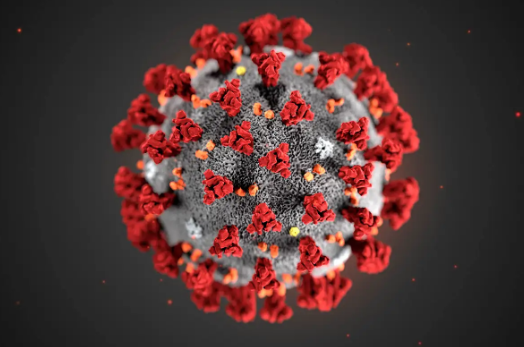

In this section we will be looking at the risk factors that contribute to the spread of COVID-19 virus. Furthermore, we will understand how to create a model to predict wheather a perticular person would contract the virus. From our knowladge we know that there are no cures for a virus. Hence, only preventive measures could be taken. Since, there is no current vaccine available, we will have to look at what factors that contributes to the strength/weakness of the human immune system.  

If you are looking to predict for a *region* then please use mode for categorical fields and median for numerical fields.

Finally we would be looking at a random forest classifier for the prediction model.

Variables that should be used for the modeling;

* Each row represents a person. 

The **target variable (y)** has three categories. 
That is the person;
* 'Did not contract the virus'-People who have been in close unprotedced contact with a COVID19 patient. High certinity of virus contact (such as touching between the two) should be verified for good quality data.
* 'Did contract and survived' -People who got cured from the illness.
* 'Contracted and died'       -People who died from the illness

**For the independant (*Xi*) variables we could use;**

1. Country Name- Where the person is from or currently living in.
2. State/region/District/province- The area which, the person resides. (Some contries may not have states)
3. City or Suberb or regional- The metro the person is living in (People in cities and suberbs have more chance of      contracting the virus. This relates to population density)
4. Does use public transport- Yes, No
5. Does have other illness- Yes, No (Could create separate variables for different illnesses if needed such as heart 
   disease, diabetes, lung disease to find which disease has the most effect on cntrating the virus.)
6. Age of the person- This variable could be grouped to an ordinal variable such as age groups.
7. Exposure to contries that have the virus at the moment.(This may be affected due to countries shutting                down). i.e. the number of returnees from affected countries who are in the perticular person's area of residence.
8. Is the countries of which, the returnees are coming from raging with the virus at the moment of return- Yes/No
9. Local customs; Outgoing, greeting by hugging/kissing, kissing monuments ad places of workship.-Yes/No (Could          create several variables for different customs).
10. percentage of old people in the country.
11. Smoke-(Moderate, Regular, No)
12. Drink Alcohal-(Moderate, Regular, No)
13. Does drugs-(yes, no)
14. Does the person get enough of good sleep on a regular basis-(Yes, No) (This could be atrributed to a persons life style such as perticualr jobs. eg:-DJ's)
15. We could also create a variable for race. This is to figure out which race is more prone to get this disease         since we are very challanged for resources. (Nothing racial please)
16. We could also have variables for the fodd that we eat such as rice, wheat, spices (garlic, ginger etc), etc..
17. Furthermore, we could create a variable for the weather/season in the area of the person that got contracted. Since the weather could have an impact on the spread of the virus.
18. Had governmnet taken precautionary measures.?- Yes/No.

By gathering data from various resources we would be able to create a table from this varibles and feed it into a machine learning alorithm to create a model. Furthermore, we could also see which factors are the most important risk factors for COVID-19 by using the feature importance feature. Which, will help identify people who are more at risk and use preventive measures as well as reactive measures in a way that allows more effective way of utilising very limited resources at this time.

Finally I would like to note that this not some sort of a virus attack by an enemy country. Since, for example lets imagine a hypothetical situation;

Where, USA attacks china with the virus. With its contagious nature it affects an Italian business person who is on a business trip in China. Furthemore, this person has family in New York and they are in Italy at this time. The businessman goes to Italy and meets his relatives from the US. They contract the virus and go to US after the holiday. Hence, the virus has hit USA. So we could conclude that these measures are suicidal. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from random import random


In [ ]:
PATH_WEEK2='/kaggle/input/covid19-global-forecasting-week-3'
df_train = pd.read_csv(f'{PATH_WEEK2}/train.csv')
df_test = pd.read_csv(f'{PATH_WEEK2}/test.csv')
df_train.head()
df_test.head()
df_train.rename(columns={'Country_Region':'Country'}, inplace=True)
df_test.rename(columns={'Country_Region':'Country'}, inplace=True)

df_train.rename(columns={'Province_State':'State'}, inplace=True)
df_test.rename(columns={'Province_State':'State'}, inplace=True)

df_train['Date'] = pd.to_datetime(df_train['Date'], infer_datetime_format=True)
df_test['Date'] = pd.to_datetime(df_test['Date'], infer_datetime_format=True)

df_train.info()
df_test.info()

y1_Train = df_train.iloc[:, -2]
y1_Train.head()
y2_Train = df_train.iloc[:, -1]
y2_Train.head()

EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

In [ ]:
#X_Train = df_train.loc[:, ['State', 'Country', 'Date']]
X_Train = df_train.copy()

X_Train['State'].fillna(EMPTY_VAL, inplace=True)
X_Train['State'] = X_Train.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_Train.loc[:, 'Date'] = X_Train.Date.dt.strftime("%m%d")
X_Train["Date"]  = X_Train["Date"].astype(int)

X_Train.head()

#X_Test = df_test.loc[:, ['State', 'Country', 'Date']]
X_Test = df_test.copy()

X_Test['State'].fillna(EMPTY_VAL, inplace=True)
X_Test['State'] = X_Test.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_Test.loc[:, 'Date'] = X_Test.Date.dt.strftime("%m%d")
X_Test["Date"]  = X_Test["Date"].astype(int)

X_Test.head()

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

X_Train.Country = le.fit_transform(X_Train.Country)
X_Train['State'] = le.fit_transform(X_Train['State'])

X_Train.head()

X_Test.Country = le.fit_transform(X_Test.Country)
X_Test['State'] = le.fit_transform(X_Test['State'])

X_Test.head()

df_train.head()
df_train.loc[df_train.Country == 'Afghanistan', :]
df_test.tail()

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

#from xgboost import XGBRegressor

#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

countries = X_Train.Country.unique()

#models_C = {}
#models_F = {}

df_out = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': [], 'Fatalities': []})

for country in countries:
    states = X_Train.loc[X_Train.Country == country, :].State.unique()
    #print(country, states)
    # check whether string is nan or not
    for state in states:
        X_Train_CS = X_Train.loc[(X_Train.Country == country) & (X_Train.State == state), ['State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities']]
        
        y1_Train_CS = X_Train_CS.loc[:, 'ConfirmedCases']
        y2_Train_CS = X_Train_CS.loc[:, 'Fatalities']
        
        X_Train_CS = X_Train_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_Train_CS.Country = le.fit_transform(X_Train_CS.Country)
        X_Train_CS['State'] = le.fit_transform(X_Train_CS['State'])
        
        X_Test_CS = X_Test.loc[(X_Test.Country == country) & (X_Test.State == state), ['State', 'Country', 'Date', 'ForecastId']]
        
        X_Test_CS_Id = X_Test_CS.loc[:, 'ForecastId']
        X_Test_CS = X_Test_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_Test_CS.Country = le.fit_transform(X_Test_CS.Country)
        X_Test_CS['State'] = le.fit_transform(X_Test_CS['State'])
        
        #models_C[country] = gridSearchCV(model, X_Train_CS, y1_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        #models_F[country] = gridSearchCV(model, X_Train_CS, y2_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        
        model1 = GradientBoostingClassifier(n_estimators=1000)
        model1.fit(X_Train_CS, y1_Train_CS)
        y1_pred = model1.predict(X_Test_CS)
        
        model2 = GradientBoostingClassifier(n_estimators=1000)
        model2.fit(X_Train_CS, y2_Train_CS)
        y2_pred = model2.predict(X_Test_CS)
        
        df = pd.DataFrame({'ForecastId': X_Test_CS_Id, 'ConfirmedCases': y1_pred, 'Fatalities': y2_pred})
        df_out = pd.concat([df_out, df], axis=0)
    # Done for state loop
# Done for country Loop

In [ ]:
df_out.ForecastId = df_out.ForecastId.astype('int')
df_out.tail()
df_out.to_csv('submission.csv', index=False)